## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        # Calibrate the camera
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

## Helper Functions

In [2]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
#     return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def warp(img, pts):
    img_size = (img.shape[1], img.shape[0])
    src = pts
    offset = 100
    dst = np.float32([[384, 0], [896, 0], 
                                     [896, 720], 
                                     [384, 720]])
    M = cv2.getPerspectiveTransform(src, dst)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    return warped, Minv


In [3]:
# Define a class to receive the characteristics of each line detection
class LaneLine():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.allfits = []
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
#         self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = []
        #y values for detected line pixels
        self.ally = [] 
        
    def best_fit(self, n):
        if (len(self.allfits) == 0):
            return self.current_fit
        if (n < len(self.allfits)):
            avg = sum(self.allfits[len(self.allfits) - n:])/n
        else:
            avg = sum(self.allfits)/len(self.allfits)
        return avg

## Main Video Pipeline

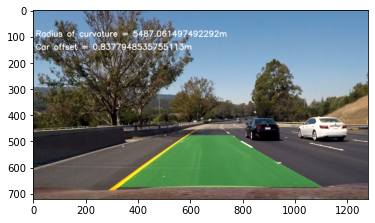

In [8]:
def measure_curvature_pixels(ploty, left_fit, right_fit):
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = np.max(ploty)
    if (left_fit is not None):
        left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    else:
        left_curverad = None
        
    if (right_fit is not None):
        right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    else:
        right_curverad = None
        
    return left_curverad, right_curverad

def find_lane_pixels(warp_frame, left_line=None, right_line=None):
    
    histogram = np.sum(warp_frame[warp_frame.shape[0]//2:,:], axis=0)
    out_img = np.dstack((warp_frame, warp_frame, warp_frame))*255
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    nwindows = 9
    margin = 100
    minpix = 50
    
    window_height = np.int(warp_frame.shape[0]//nwindows)
    nonzero = warp_frame.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    left_lane_inds = []
    right_lane_inds = []
    
    for window in range(nwindows):
        win_y_low = warp_frame.shape[0] - (window+1)*window_height
        win_y_high = warp_frame.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2)
        
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
            
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
            
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    return leftx, lefty, rightx, righty, out_img

def fit_polynomial(warp_frame, leftx=None, lefty=None, rightx=None, righty=None, left_lane=None, right_lane=None):
    left_pfit = left_lane.current_fit
    right_pfit = right_lane.current_fit
    if all(side is None for side in [leftx, lefty, rightx, righty]):
        leftx, lefty, rightx, righty, out_img = find_lane_pixels(warp_frame)
        
    ploty = np.linspace(0, warp_frame.shape[0]-1, warp_frame.shape[0])
    
    if (len(rightx) == 0 or len(righty) == 0):
        right_fit = right_lane.best_fit(20)
    else:
        right_fit = np.polyfit(righty, rightx, 2)
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    right_lane.current_fit = right_fit
        
        
    if (len(leftx) == 0 or len(lefty) == 0):
        left_fit = left_lane.best_fit(20)
    else:
        left_fit = np.polyfit(lefty, leftx, 2)
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    left_lane.current_fit = left_fit

    
    right_lane.allfits.append(right_fit)
    left_lane.allfits.append(left_fit)
    #sanity check
    curve_thresh = 50000
    left_pcurve = left_lane.radius_of_curvature
    right_pcurve = right_lane.radius_of_curvature
        
    left_lane.radius_of_curvature, right_lane.radius_of_curvature = measure_curvature_pixels(ploty, left_fit, right_fit)
    
#     if (right_pcurve is not None and abs(right_pcurve - right_lane.radius_of_curvature) >= curve_thresh):
#         right_lane.allfits.pop()
#         right_fit = right_lane.best_fit(10)
#         right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
#         right_lane.current_fit = right_fit
#         left_lane.radius_of_curvature, right_lane.radius_of_curvature = measure_curvature_pixels(ploty, left_fit, right_fit)
#         right_lane.allfits.append(right_fit)
    
#     if (left_pcurve is not None and abs(left_pcurve - left_lane.radius_of_curvature) >= curve_thresh):
#         left_lane.allfits.pop()
#         left_fit = left_lane.best_fit(10)
#         left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#         left_lane.current_fit = left_fit
#         left_lane.radius_of_curvature, right_lane.radius_of_curvature = measure_curvature_pixels(ploty, left_fit, right_fit)
#         left_lane.allfits.append(left_fit)
        
        
    poly_thresh = 100
    
    left_diff = sum([abs(left_fit[0] - left_pfit[0]),
                     abs(left_fit[1] - left_pfit[1]),
                     abs(left_fit[2] - left_pfit[2])])
    
    right_diff = sum([abs(right_fit[0] - right_pfit[0]),
                      abs(right_fit[1] - right_pfit[1]),
                      abs(right_fit[2] - right_pfit[2])])

    if (left_diff >= poly_thresh):
        left_lane.allfits.pop()
        left_fit = left_lane.best_fit(10)
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        left_lane.current_fit = left_fit
        left_lane.radius_of_curvature, right_lane.radius_of_curvature = measure_curvature_pixels(ploty, left_fit, right_fit)
        left_lane.allfits.append(left_fit)
                      
    if (right_diff >= poly_thresh):
        right_lane.allfits.pop()
        right_fit = right_lane.best_fit(10)
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        right_lane.current_fit = right_fit
        left_lane.radius_of_curvature, right_lane.radius_of_curvature = measure_curvature_pixels(ploty, left_fit, right_fit)
        right_lane.allfits.append(right_fit)
        
    curvature = (left_lane.radius_of_curvature + right_lane.radius_of_curvature)/2
    lane_centre = (right_fitx[0] - left_fitx[0])/2 + left_fitx[0]
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    offset = abs(640-lane_centre)
    offset = offset*xm_per_pix
#     print(lane_centre)
    return left_fitx, right_fitx, left_fit, right_fit, ploty, offset, curvature
    

def lane_line_pipeline(img, left_fit=None, right_fit=None, left_lane=None, right_lane=None):
#     # Undistort Image
    frame = cv2.undistort(img, mtx, dist, None, mtx)
    
    # Apply Color Thresh
    hls = cv2.cvtColor(frame, cv2.COLOR_RGB2HLS)
    lab = cv2.cvtColor(frame, cv2.COLOR_RGB2LAB)
    s_channel = hls[:,:,2]
    
    b_channel = lab[:,:,0]
    
    
    # Threshold color channel
    s_thresh_min = 170
    s_thresh_max = 255
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    
    # Threshold color channel
    b_thresh_min = 225
    b_thresh_max = 255
    b_binary = np.zeros_like(b_channel)
    b_binary[(b_channel >= b_thresh_min) & (b_channel <= b_thresh_max)] = 1
    
    sobelx = cv2.Sobel(b_binary, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    thresh_min = 20
    thresh_max = 100
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    frame = combined_binary
    
    # Apply Perspective Transform
    top_left = [581, 477]
    top_right = [699, 477]
    bottom_right = [896,675]
    bottom_left = [384,675]
    pts = np.array([top_left, top_right, bottom_right, bottom_left])
    warp_frame, Minv = warp(frame, np.float32([pts]))
    
    # Detect Lines
    if all(side is not None for side in [left_fit, right_fit]):
        margin = 80
        nonzero = warp_frame.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        
        left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                         left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                         left_fit[1]*nonzeroy + left_fit[2] + margin)))
        right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                         right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                         right_fit[1]*nonzeroy + right_fit[2] + margin)))
        
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        
    left_fitx, right_fitx, left_fit, right_fit, ploty, offset, curvature = fit_polynomial(warp_frame, left_lane=left_lane, right_lane=right_lane)
    
    # Final Render
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warp_frame).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result, "Radius of curvature = " + str(curvature) + "m", (10,100), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(result, "Car offset = " + str(offset) + "m", (10,150), font, 1, (255, 255, 255), 2, cv2.LINE_AA)

    return result, left_fit, right_fit

left_lane = LaneLine()
right_lane = LaneLine()
left_lane.current_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_lane.current_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])



view = plt.figure()
image = mpimg.imread("test_images/test6.jpg")
final = lane_line_pipeline(image, left_lane=left_lane, right_lane=right_lane)
plt.imshow(final[0])
plt.show()

# Project Video

In [5]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import PIL.Image

In [9]:
left_fit = None
right_fit = None

left_lane = LaneLine()
right_lane = LaneLine()
left_lane.current_fit = np.array([ 2.13935315e-04, -3.77507980e-01,  4.76902175e+02])
right_lane.current_fit = np.array([4.17622148e-04, -4.93848953e-01,  1.11806170e+03])

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    global left_fit, right_fit, left_lane, right_lane
    result, left_fit, right_fit = lane_line_pipeline(image, left_lane=left_lane, right_lane=right_lane)

    return result

white_output = "output_images/project_video.mp4"
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("project_video.mp4").subclip(21,30)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

Moviepy - Building video output_images/project_video.mp4.
Moviepy - Writing video output_images/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_images/project_video.mp4
Wall time: 2min 48s
